# Peppercorn Counter

#### Importing the used libraries

In [1]:
import numpy as np
from scipy import ndimage as ndim
from scipy.ndimage import median_filter
from skimage import (filters, io, morphology)
from skimage.feature import peak_local_max
from skimage.morphology.selem import disk
from skimage.segmentation import watershed
import matplotlib.pyplot as plt

#### Importing the image

In [2]:
# change default colormap
plt.rcParams['image.cmap'] = 'gray'  

input_image = io.imread("input.tif")

#### Operations on FFT
*1. Creating the FFT*

In [3]:
input_image_fft = np.fft.fftshift(np.fft.fft2(input_image))

*2. Edit the FFT, to remove the grid*

In [4]:
# remove high value pixels outside of fft image core
# --> removes the grid on the image
radius = 30
center = 430

input_image_fft_edit = input_image_fft.copy()
for x in range(int(np.sqrt(input_image_fft_edit.size))):
    for y in range(int(np.sqrt(input_image_fft_edit.size))):
        if ((x > (center + radius) or x < (center - radius)) 
             or (y > (center + radius) or y < (center - radius))):
            if (np.log(abs(input_image_fft_edit[x, y])) > 12):
                input_image_fft_edit[x, y] = np.complex128(1)

*3. Create IFFT from edited FFT*

In [5]:
input_image_ifft = abs(np.fft.ifft2(input_image_fft_edit))

In [6]:
median_img = median_filter(input_image_ifft, 4)

#### Output of the images

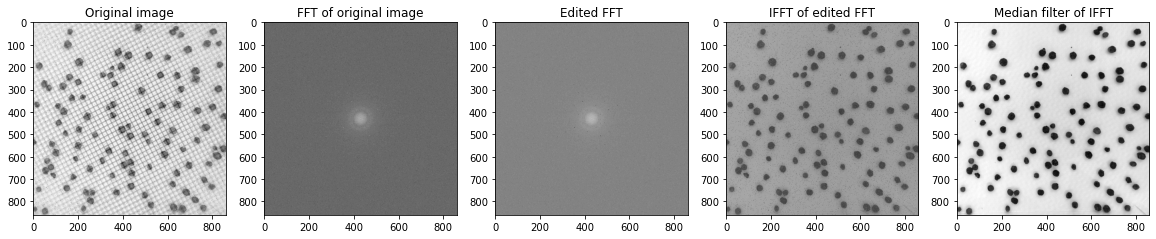

In [7]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 10))
ax[0].title.set_text('Original image')
ax[0].imshow(input_image)
ax[1].title.set_text('FFT of original image')
ax[1].imshow(np.log(abs(input_image_fft)), cmap='gray')
ax[2].title.set_text('Edited FFT')
ax[2].imshow(np.log(abs(input_image_fft_edit)), cmap='gray')
ax[3].title.set_text('IFFT of edited FFT')
ax[3].imshow(input_image_ifft, cmap='gray')
ax[4].title.set_text('Median filter of IFFT')
ax[4].imshow(median_img)

#### Compute histogram of image

In [8]:
histogram, bin_edges = np.histogram(input_image_fft, bins=256, range=(0, 255))

C:\ProgramData\Miniconda3\lib\site-packages\numpy\lib\histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)


#### Compute Threshold

In [9]:
threshold = filters.threshold_otsu(median_img)
print("Threshold locatetd at grey-value: {}".format(threshold))

Threshold locatetd at grey-value: 161.30954762280115


#### Compute Binary Mask

In [10]:
# compute mask where value smaller than treshold
binary_mask = median_img < threshold

#### Compute masked image

In [11]:
# use the binary_mask to remove the background
masked_img = np.zeros_like(median_img)
masked_img[binary_mask] = median_img[binary_mask]

#### Compute morphology & segmentation for image
Two separate algorithms to confirms the result of each other

*1. Usage of erosion/dilation*

In [12]:
erosion_radius = 10
erosion_img = morphology.dilation(masked_img, disk(erosion_radius/3))
erosion_img = morphology.erosion(erosion_img, disk(erosion_radius))

*2. Usage of watershed algorithm*

In [13]:
distance = ndim.distance_transform_edt(binary_mask)
coords = peak_local_max(distance, min_distance=7)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndim.label(mask)
segmented_image = watershed(-distance, markers, mask=binary_mask, watershed_line=True)

#### Calculate amount of peppercorns

In [14]:
min_d = 6

distance = ndim.distance_transform_edt(segmented_image)
coordinates = peak_local_max(distance, min_distance=min_d)
print("Watershed Algorithm: \tAmount of corns found: {}".format(len(coordinates)))

distance = ndim.distance_transform_edt(erosion_img)
coordinates = peak_local_max(distance, min_distance=min_d)
print("Erosion/Dilation: \tAmount of corns found: {}".format(len(coordinates)))

Watershed Algorithm: 	Amount of corns found: 110
Erosion/Dilation: 	Amount of corns found: 110


#### Output of the images

C:\ProgramData\Miniconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


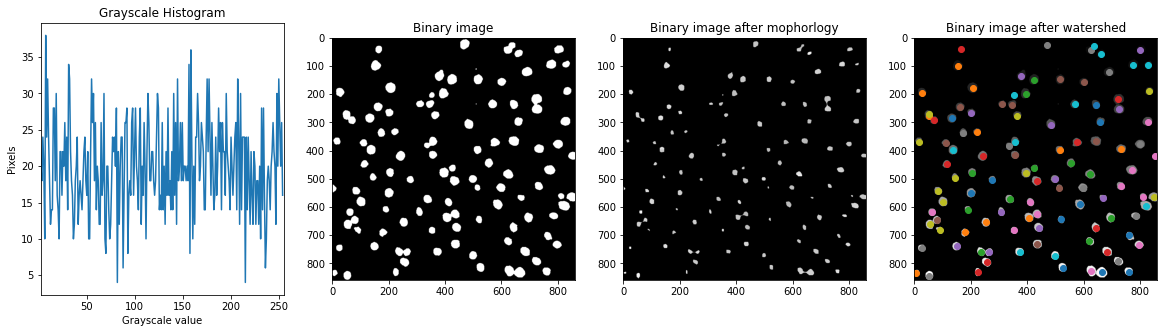

In [15]:
fig, ax = plt.subplots(ncols=4,figsize=(20,5))
ax[0].plot(bin_edges[0:-1], histogram)
ax[0].title.set_text('Grayscale Histogram')
ax[0].set_xlabel('Grayscale value')
ax[0].set_ylabel('Pixels')
ax[0].set_xlim(2,255)
ax[1].title.set_text('Binary image')
ax[1].imshow(binary_mask)
ax[2].title.set_text('Binary image after mophorlogy')
ax[2].imshow(erosion_img)
ax[3].title.set_text('Binary image after watershed')
ax[3].imshow(segmented_image)
for (y, x) in coordinates:
        ax[3].scatter(x, y)